# Regressorion with Orbit - Advance I
In this demo, we want to demonstartate further how to config orbit to perform regressions along with temporal components.  The config including different regularizations and we use a simulated data set to compare against ground truth. 

__IMPORTANT:__ This notebook only works under python 3.6 due to a bug related to matplotlib.

In [1]:
import pandas as pd
import numpy as np
import scipy
import gc
import random


import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

import pystan

from orbit.models.lgt import LGTMAP, LGTAggregated, LGTFull
from orbit.models.dlt import DLTMAP, DLTAggregated, DLTFull
from orbit.diagnostics.metrics import mse

from orbit.diagnostics.plot import plot_posterior_params
from orbit.constants.palette import QualitativePalette
from orbit.utils.simulation import make_ts_multiplicative, make_trend, make_seasonality, make_regression

In [2]:
# randomization is using numpy with this version
print("np version: {}".format(np.__version__))
print("scipy version: {}".format(scipy.__version__))
print("pystan version: {}".format(pystan.__version__))

np version: 1.18.2
scipy version: 1.4.1
pystan version: 2.19.1.1


## Simulation of regression with time-series

We first generate the coefficients for benchmarking.

In [3]:
SEED = 2020
NUM_OF_REGRESSORS = 10
SERIES_LEN = 300
SEASONALITY = 52 
# sample some coefficients
COEFS = np.random.default_rng(SEED).uniform(0.1, 0.5, NUM_OF_REGRESSORS)
SIGNS = np.random.default_rng(SEED).choice([1, -1], NUM_OF_REGRESSORS)
COEFS = COEFS * SIGNS
COEFS

array([ 0.28732302,  0.30573689, -0.44559531, -0.38775475, -0.23339915,
       -0.45266545,  0.30746595, -0.30928777,  0.38895548,  0.27871302])

Now we generate observations $y$ such that $$y=l(t)+s(t)+r(t)$$
where $$r(t) = \sum_i \beta_i{x_{i,t}}^T $$ is our regression component with $\beta$ and $x_t$ represent coefficients and regressors at time $t$ respectively. 

In [4]:
trend = make_trend(series_len=SERIES_LEN, rw_loc=0.01, rw_scale=0.1, method='rw', seed=SEED)
seas = make_seasonality(series_len=SERIES_LEN, seasonality=SEASONALITY, method='discrete', seed=SEED)
X, y, coefs = make_regression(series_len=SERIES_LEN, coefs=COEFS, noise_scale=0.1)
y = np.expand_dims(y + trend + seas, -1)
print(y.shape, X.shape)

(300, 1) (300, 10)


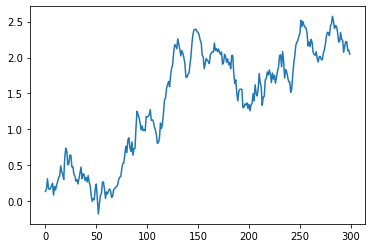

In [5]:
plt.plot(trend)

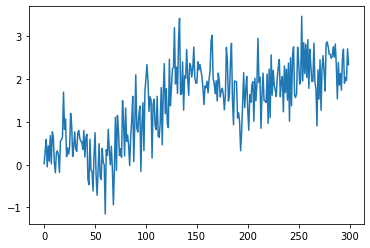

In [6]:
plt.plot(y)

In [7]:
x_cols = [f"x{x}" for x in range(1, NUM_OF_REGRESSORS + 1)]
response_col = "y"
dt_col = "date"
obs_matrix = np.concatenate([y, X], axis=1)
# make a data frame for orbit inputs
df = pd.DataFrame(obs_matrix, columns=[response_col] + x_cols)
# make some dummy date stamp
dt = pd.date_range(start='2016-01-04', periods=SERIES_LEN, freq="1W")
df['date'] = dt
print(df.shape)

(300, 12)


## Regression with full regressors
Note that at this point, we simulate response with full rank of $x$ meaning all regressors contribute to the response.

In [9]:
mod_ridge = DLTFull(
    response_col=response_col,
    date_col=dt_col,
    regressor_col=x_cols,
    seasonality=SEASONALITY,
    seed=SEED,
    num_warmup=4000,
    num_sample=1000,
)
mod_ridge.fit(df=df)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_238ab4289aafde2046beb9f0943c77f5 NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [10]:
coef_ridge = np.quantile(mod_ridge._posterior_samples['rr_beta'], q=[0.05, 0.5, 0.95], axis=0 )

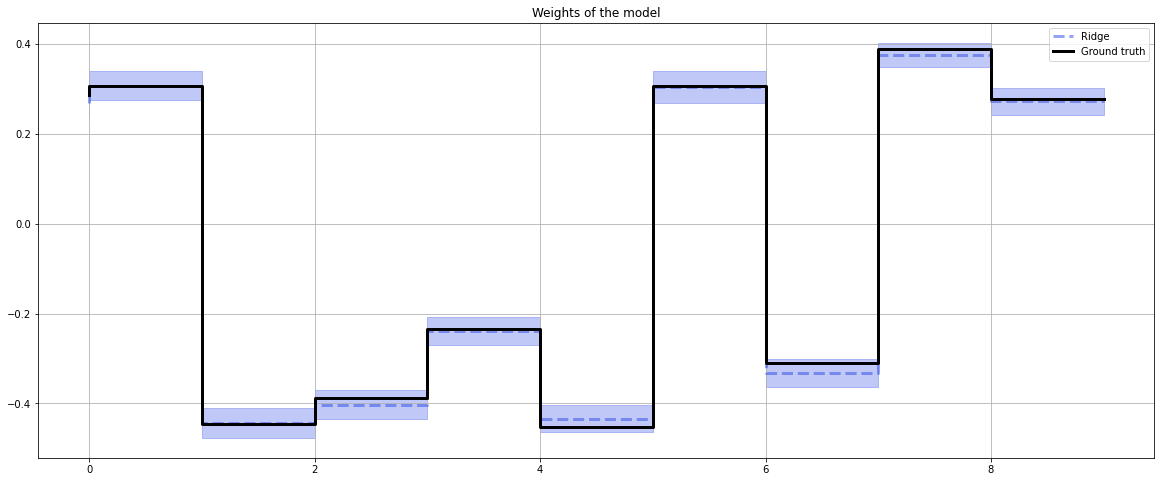

In [11]:
lw=3
idx = np.arange(NUM_OF_REGRESSORS)
plt.figure(figsize=(20, 8))
plt.title("Weights of the model")
plt.plot(idx, coef_ridge[1], color=QualitativePalette.Line4.value[2], linewidth=lw,  drawstyle='steps', label="Ridge", alpha=0.5, linestyle='--')
plt.fill_between(idx, coef_ridge[0], coef_ridge[2], step='pre', alpha=0.3, color=QualitativePalette.Line4.value[2])
plt.plot(coefs, color="black", linewidth=lw,  drawstyle='steps', label="Ground truth")
plt.legend()
plt.grid()

The model seems to fully recover the true coefficients. However, we assumed a full relevence of our regressors which is always the case.

## Regression with sparsity and irrelevant regressors
Now, we assume there exists some irrelevant regressors in our inputs and high sparsity in our observed regressors values. We then compare a few settings with bayesian regression.

In [12]:
NUM_OF_REGRESSORS = 50
SERIES_LEN = 300
# sample some coefficients
COEFS = np.random.default_rng(SEED).uniform(0.1, 0.5, NUM_OF_REGRESSORS)
SIGNS = np.random.default_rng(SEED).choice([1, -1], NUM_OF_REGRESSORS)
COEFS = COEFS * SIGNS

In [13]:
trend = make_trend(series_len=SERIES_LEN, rw_loc=0.01, rw_scale=0.1, method='rw', seed=SEED)
seas = make_seasonality(series_len=SERIES_LEN, seasonality=SEASONALITY, method='discrete', seed=SEED)
X, y, coefs = make_regression(series_len=SERIES_LEN, coefs=COEFS, relevance=0.2, sparsity=0.2)
y = np.expand_dims(y + trend + seas, -1)
coefs

array([ 0.        ,  0.        ,  0.        , -0.38775475,  0.        ,
        0.        ,  0.30746595,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -0.47868683,  0.        ,
       -0.13671857,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.38408665,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.48168938,  0.        , -0.26563251,  0.        ,  0.        ,
        0.        ,  0.29753936,  0.        , -0.47645482,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.48670835,  0.        ,  0.        ,  0.        ])

In [14]:
x_cols = [f"x{x}" for x in range(1, NUM_OF_REGRESSORS + 1)]
response_col = "y"
dt_col = "date"
obs_matrix = np.concatenate([y, X], axis=1)
# make a data frame for orbit inputs
df = pd.DataFrame(obs_matrix, columns=[response_col] + x_cols)
# make some dummy date stamp
dt = pd.date_range(start='2016-01-04', periods=SERIES_LEN, freq="1W")
df['date'] = dt
print(df.shape)

(300, 52)


In [15]:
mod_ridge = DLTFull(
    response_col=response_col,
    date_col=dt_col,
    regressor_col=x_cols,
    seasonality=SEASONALITY,
    seed=SEED,
    num_warmup=8000,
    num_sample=1000,
    stan_mcmc_control={'adapt_delta':0.9},
)
mod_ridge.fit(df=df)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


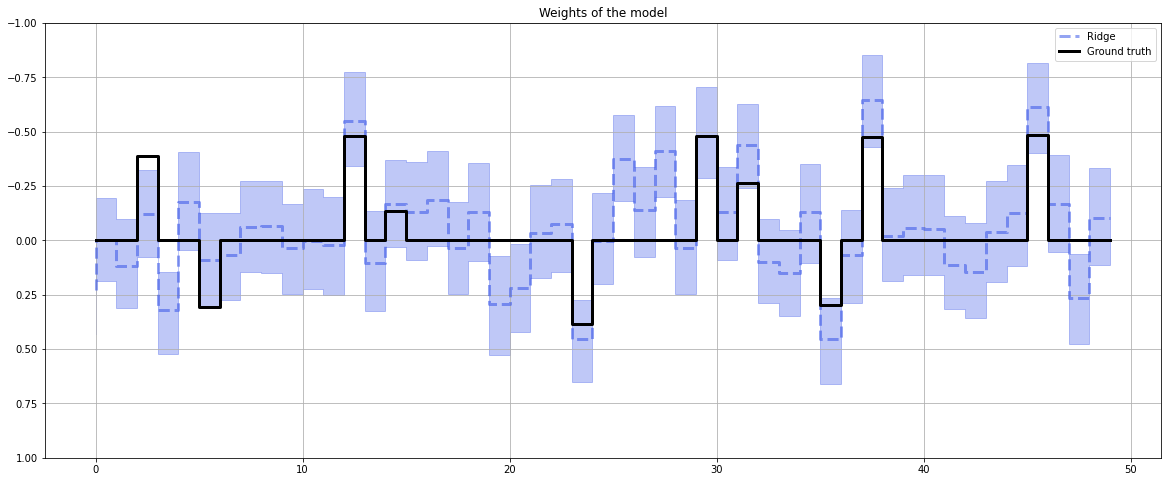

In [31]:
coef_ridge = np.quantile(mod_ridge._posterior_samples['rr_beta'], q=[0.05, 0.5, 0.95], axis=0 )
lw=3
idx = np.arange(NUM_OF_REGRESSORS)
plt.figure(figsize=(20, 8))
plt.title("Weights of the model")
plt.plot(idx, coef_ridge[1], color=QualitativePalette.Line4.value[2], linewidth=lw,  drawstyle='steps', label="Ridge", alpha=0.5, linestyle='--')
plt.fill_between(idx, coef_ridge[0], coef_ridge[2], step='pre', alpha=0.3, color=QualitativePalette.Line4.value[2])
plt.plot(coefs, color="black", linewidth=lw,  drawstyle='steps', label="Ground truth")
plt.ylim(1, -1)
plt.legend()
plt.grid()

In [17]:
print(mse(coefs, coef_ridge))

0.05491325247156536


Although ridge can recover the useful coefficients, it also creates a lot of false positive.

In [18]:
mod_lasso = DLTFull(
    response_col=response_col,
    date_col=dt_col,
    regressor_col=x_cols,
    seasonality=SEASONALITY,
    seed=SEED,
    regression_penalty='lasso',
    lasso_scale=0.1,
    num_warmup=8000,
    num_sample=1000,
    stan_mcmc_control={'adapt_delta':0.9},
)
mod_lasso.fit(df=df)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


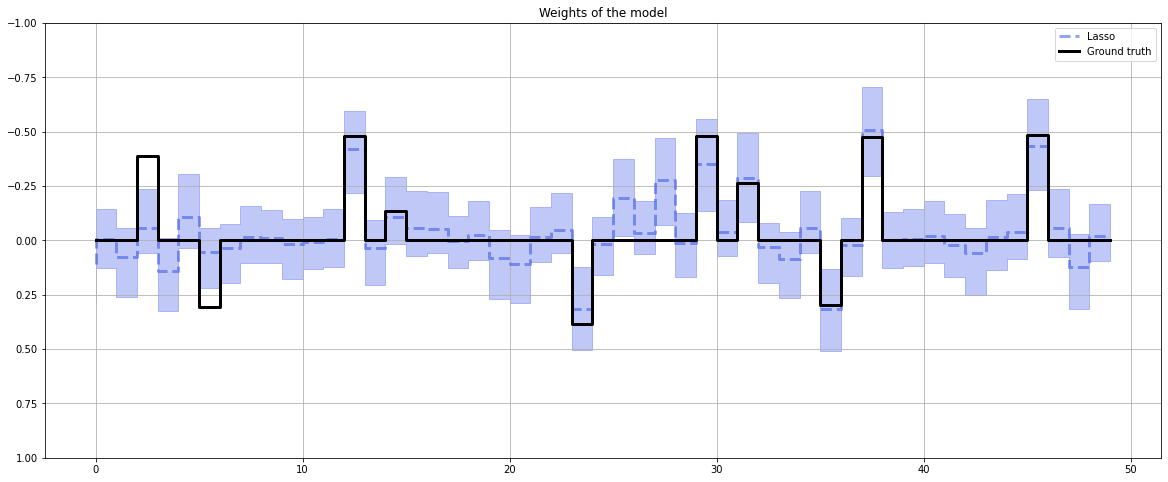

In [32]:
coef_lasso = np.quantile(mod_lasso._posterior_samples['rr_beta'], q=[0.05, 0.5, 0.95], axis=0 )
lw=3
idx = np.arange(NUM_OF_REGRESSORS)
plt.figure(figsize=(20, 8))
plt.title("Weights of the model")
plt.plot(idx, coef_lasso[1], color=QualitativePalette.Line4.value[2], linewidth=lw,  drawstyle='steps', label="Lasso", alpha=0.5, linestyle='--')
plt.fill_between(idx, coef_lasso[0], coef_lasso[2], step='pre', alpha=0.3, color=QualitativePalette.Line4.value[2])
plt.plot(coefs, color="black", linewidth=lw,  drawstyle='steps', label="Ground truth")
plt.ylim(1, -1)
plt.legend()
plt.grid()

In [20]:
print(mse(coefs, coef_lasso))

0.0254550812334557


As we can see, using LASSO i.e. double exponential prior in Bayesian regression reduces some error by shrinkage the coeffecients.

In [27]:
mod_hs = DLTFull(
    response_col=response_col,
    date_col=dt_col,
    regressor_col=x_cols,
    seasonality=SEASONALITY,
    seed=SEED,
    regression_penalty='horseshoe',
    num_warmup=8000,
    num_sample=1000,
    expected_size=10,
    stan_mcmc_control={'adapt_delta':0.9},
)
mod_hs.fit(df=df)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0e66d3a55ebce572cee8c1409a50bb61 NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


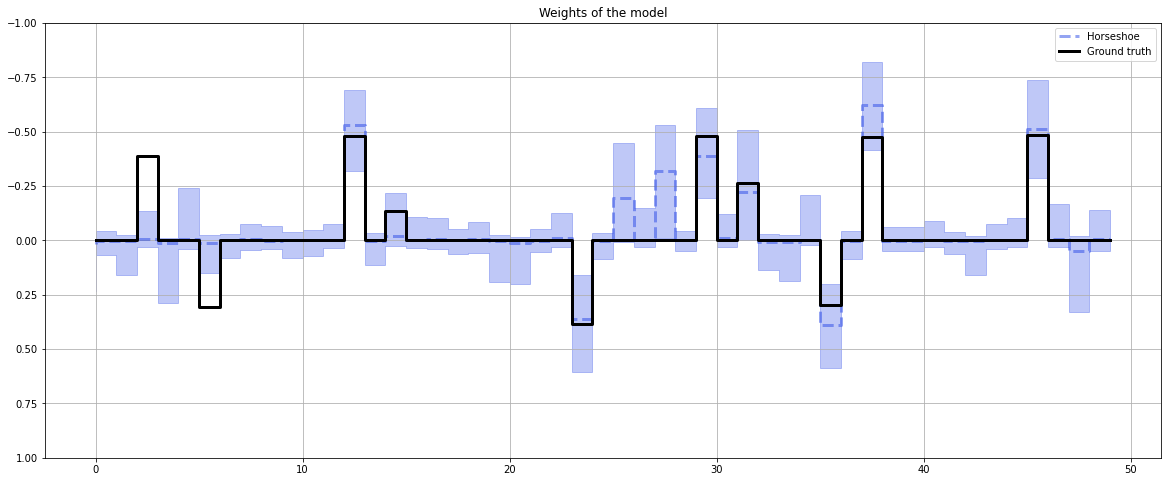

In [33]:
coef_hs = np.quantile(mod_hs._posterior_samples['rr_beta'], q=[0.05, 0.5, 0.95], axis=0 )
lw=3
idx = np.arange(NUM_OF_REGRESSORS)
plt.figure(figsize=(20, 8))
plt.title("Weights of the model")
plt.plot(idx, coef_hs[1], color=QualitativePalette.Line4.value[2], linewidth=lw,  drawstyle='steps', label="Horseshoe", alpha=0.5, linestyle='--')
plt.fill_between(idx, coef_hs[0], coef_hs[2], step='pre', alpha=0.3, color=QualitativePalette.Line4.value[2])
plt.plot(coefs, color="black", linewidth=lw,  drawstyle='steps', label="Ground truth")
plt.ylim(1, -1)
plt.legend()
plt.grid()

In [30]:
print(mse(coefs, coef_hs))

0.01901503962044066


Finally, we see a further reduction of errors mainly due to the reduction of false positive by using `horseshore` prior.  Such prior is still under experimentation.  You may expect higher number of divergent iteraions.  Increasing `adapt_delta` in stan can help in many cases suggested by other articles.

## Reference

- Piironen, J., Vehtari1, A. (2017)  “Comparison of Bayesian Predictive Methods for Model Selection.” Statistics and Computing 27 (3): 711–35. [doi:10.1007/s11222-016-9649-y](https://doi.org/10.1007/s11222-016-9649-y)
- Piironen, J., Vehtari1, A. (2017) "On the Hyperprior Choice for the Global Shrinkage Parameter in the Horseshoe Prior", [arXiv:](https://en.wikipedia.org/wiki/ArXiv)[1610.05559v2 ](https://arxiv.org/abs/1610.05559)
- Carvalho, Carlos M., Nicholas G. Polson, and James G. Scott. 2009. “Handling Sparsity via the Horseshoe.” In Proceedings of the Twelth International Conference on Artificial Intelligence and Statistics, edited by David van Dyk and Max Welling, 5:73–80. Proceedings of Machine Learning Research. Hilton Clearwater Beach Resort, Clearwater Beach, Florida USA: PMLR. http://proceedings.mlr.press/v5/carvalho09a.html.
- Park, T.  and Casel, G. (2008) "The Bayesian Lasso" Journal of the American Statistical Association
https://people.eecs.berkeley.edu/~jordan/courses/260-spring09/other-readings/park-casella.pdf